<a href="https://colab.research.google.com/github/runnin123/Jeju_Bigdata/blob/master/Jeju_manymanymodeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

project_id = 'jeju-bigquery-282708'
client = bigquery.Client(project=project_id)

train = client.query('''
  SELECT 
      * 
  FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train` 
  WHERE RAND() < 10000 / (SELECT COUNT(*) FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train`)
  ''').to_dataframe()

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

# 03 Chapter에서 추가
# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 시각화
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt  # Matlab-style plotting

# 통계
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# 06 Chapter 추가
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [ ]:
# 날짜 처리
data = train.copy()
data = data.fillna('')
print(data['REG_YYMM'].head())

0    201902
1    201907
2    201912
3    202003
4    201903
Name: REG_YYMM, dtype: int64


In [ ]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,서울,은평구,슈퍼마켓,강원,원주시,20s,1,1,3,18120,4,2019,2
1,강원,동해시,비알콜 음료점업,강원,삼척시,20s,2,1,22,279500,25,2019,7
2,강원,고성군,중식 음식점업,강원,속초시,20s,1,1,3,40000,3,2019,12
3,서울,강서구,그외 기타 종합 소매업,강원,춘천시,20s,1,2,5,300000,6,2020,3
4,강원,속초시,일식 음식점업,강원,속초시,30s,1,2,122,7446700,136,2019,3


In [ ]:
# 데이터 정제
df = data.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)

In [ ]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

In [ ]:
from sklearn.model_selection import train_test_split

X_data, y_data = df_num.loc[:, df_num.columns != 'AMT'], df.loc[:, df_num.columns == 'AMT']
y_target = y_data['AMT']
X_data = X_data.drop(['CSTMR_CNT', 'CNT'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=126, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6798, 8), (6798,), (2914, 8), (2914,))


 mu = 2679598.16 and sigma = 20402328.93



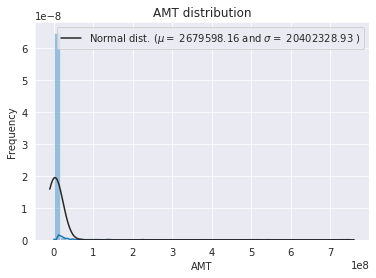

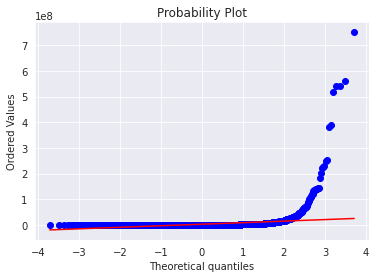

In [ ]:
sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()


 mu = 12.68 and sigma = 1.72



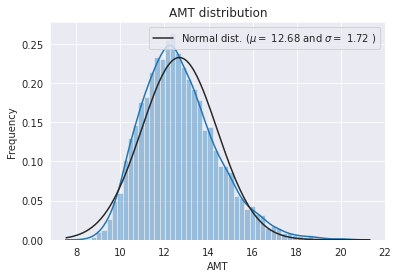

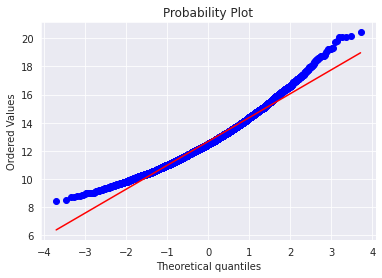

In [ ]:
y_train = np.log1p(y_train)

sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

In [ ]:
from xgboost import XGBRegressor
import xgboost
print(xgboost.__version__)

0.90


In [ ]:
import lightgbm
from lightgbm import LGBMRegressor
print(lightgbm.__version__)

2.2.3


In [ ]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=1500, learning_rate=0.1,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.1, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=1500,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.1, n_estimators=1500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11, max_depth=3)

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 1.6995 (0.0249)



In [ ]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 1.6995 (0.0249)



In [ ]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.37315e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.18559e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.51739e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=7.5257e-17): result may not be accurate.
  overwrite_a=False)


Kernel Ridge score: 1.6695 (0.0282)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.42463e-17): result may not be accurate.
  overwrite_a=False)


In [ ]:
score = rmsle_cv(model_xgb)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

XGBoost score: 1.5253 (0.0319)



In [ ]:
score = rmsle_cv(model_lgb)
print("lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

lightgbm score: 1.5964 (0.0172)



In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.37315e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.18559e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.51739e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=7.5257e-17): result may not be accurate.
  overwrite_a=False)


 Averaged base models score: 1.6098 (0.0261)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.42463e-17): result may not be accurate.
  overwrite_a=False)


In [ ]:
def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
ENet.fit(X_train, y_train)
ENet_train_pred = ENet.predict(X_train)
ENet_pred = np.expm1(ENet.predict(X_test))
print(rmsle(y_train, ENet_train_pred))

1.697416954261122


In [ ]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y_train, xgb_train_pred))

1.361854349957766


In [ ]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test))
print(rmsle(y_train, lgb_train_pred))

1.5738128583184594


In [ ]:
averaged_models.fit(X_train, y_train)
averaged_train_pred = averaged_models.predict(X_train)
averaged_pred = np.expm1(averaged_models.predict(X_test))
print(rmsle(y_train, averaged_train_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.43837e-17): result may not be accurate.
  overwrite_a=False)


1.5700236325520185


In [ ]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,averaged_train_pred*0.10 +
               xgb_train_pred*0.80 + lgb_train_pred*0.10))

RMSLE score on train data:
1.383346832129779


In [ ]:
best_model = [averaged_models, model_xgb, model_lgb]

In [ ]:
aver_reg = best_model[0]
xgb_reg = best_model[1]
lgb_reg = best_model[2]

aver_pred = aver_reg.predict(X_test)
aver_pred = np.expm1(aver_pred)

xgb_pred = xgb_reg.predict(X_test)
xgb_pred = np.expm1(xgb_pred)

lgb_pred = lgb_reg.predict(X_test)
lgb_pred = np.expm1(lgb_pred)

pred = np.array([aver_pred, xgb_pred, lgb_pred])
print(pred.shape)

pred = np.transpose(pred)
print(pred.shape)

(3, 2914)
(2914, 3)


In [ ]:
def rmsle(y, pred): 
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return print('Test Data RMSLE: {0:.3f}'.format(rmsle))

In [ ]:
final = aver_pred*0.05 + xgb_pred*0.90 + lgb_pred*0.05
rmsle(y_test, final)

Test Data RMSLE: 1.513
